[Paddy Doctor: Paddy Disease Classification](https://www.kaggle.com/competitions/paddy-disease-classification/overview)

[First Steps: Road to the Top, Part 1](https://www.kaggle.com/code/jhoward/first-steps-road-to-the-top-part-1)

# Getting set up

In [2]:
from fastkaggle import *

In [3]:
from fastai.vision.all import *

set_seed(42)

path = Path("./input")
path, path.ls()

(Path('input'),
 (#4) [Path('input/sample_submission.csv'),Path('input/test_images'),Path('input/train.csv'),Path('input/train_images')])

Now we can import the stuff we'll need from fastai, set a seed(for reproductibility - just for the purpose of making this notebook easier to write; I don't recommend doing that in your own analysis however) and check what's in data:

# Looking at the data

The images are in `train_images`, so let's grab a list of all of them:

In [4]:
trn_path = path / "train_images"
files = get_image_files(trn_path)

...and take a look at one:

(480, 640)


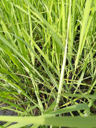

In [5]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

Looks like the images might be 480x640 -- let's check all their sizes. This is faster if we do it in pararrel, so we'll use fastcore's `parallel` for this:

In [7]:
from fastcore.parallel import *


def f(o):
    return PILImage.create(o).size


sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `max_workers` has to be changed to 0 to avoid getting stuck


(480, 640)    10403
(640, 480)        4
Name: count, dtype: int64

They're nearly all the same size, except for a few. Becuase of those few, however, we'll need to make sure we always resize each image to common dimensions first, otherwise fastai won't be able to create batches. For now, we'll just squish them to 480x480 images, and then once they're in batches we do a random resized crop down to a smaller size, along with the other default fastai augmentations provied by `aug_transforms`. We'll start out with small resized images, since we want to be able to iterate quickly.

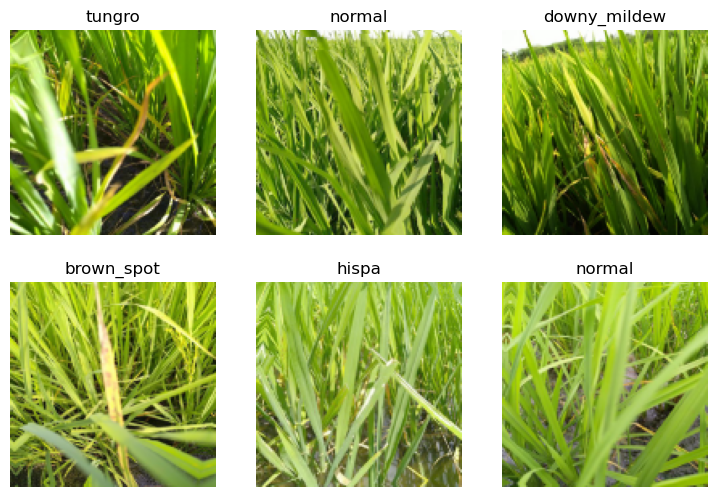

In [8]:
dls = ImageDataLoaders.from_folder(
    trn_path,
    # 훈련 데이터의 20%를 검증 데이터로
    valid_pct=0.2,
    seed=42,
    # 각 이미지를 480x480으로 변환하며, squish를 이용해 이미지를 왜곡해서라도 지정된 크기로 맞춤
    item_tfms=Resize(480, method="squish"),
    # 배치 수준에서 적용될 데이터 증강. 이미지를 128x128으로 랜덤하게 잘라내며,
    # 이미지 최소 스케일 비율을 0.75로
    batch_tfms=aug_transforms(size=128, min_scale=0.75),
)

# 배치에서 무작위로 6개 이미지 보여줌
dls.show_batch(max_n=6)

# Our first model

Let's create a model. To pick an architecture, we should look at the options in [The best vision models for fine-tuning](https://www.kaggle.com/code/jhoward/the-best-vision-models-for-fine-tuning). I like looks of `resnet26d`, which is the fastest resolution-independent model which gets into the top-15 lists there.

- resnet26d(resnet26의 변형) 사용
- 평가 지표로 오류율
- 모델 체크 포인트나 로그 파일 저장될 경로로 현재 경로
- 16비트 부동소수점 연산 사용하도록 모델 설정. 일반적으로 32비트 부동소수점으로 계산하지만 16비트 사용함으로써 메모리 사용량 줄어들고 연산 속도 빨라짐

In [9]:
learn = vision_learner(dls, "resnet26d", metrics=error_rate, path=".").to_fp16()

model.safetensors:   0%|          | 0.00/64.2M [00:00<?, ?B/s]

Let's see what the learning rate finder shows:

- lr_find로 학습 시작 전 적절한 학습률 탐색
- 학습률 추천하는 방법
    * valley: 손실이 급격히 떨어진 후 안정화되는 지점을 찾음. 학습이 효과적으로 진행될 수 있는 안정된 학습률 찾는 데 유용함.
    * 손실 함수의 가파르게 하락하는 구간 끝부분을 찾음. 학습 속도를 빠르게 하고 싶을 때 사용.

C:\Users\jiweo\anaconda3\envs\kaggle-torch\lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device

SuggestedLRs(valley=0.0010000000474974513, slide=0.00363078061491251)

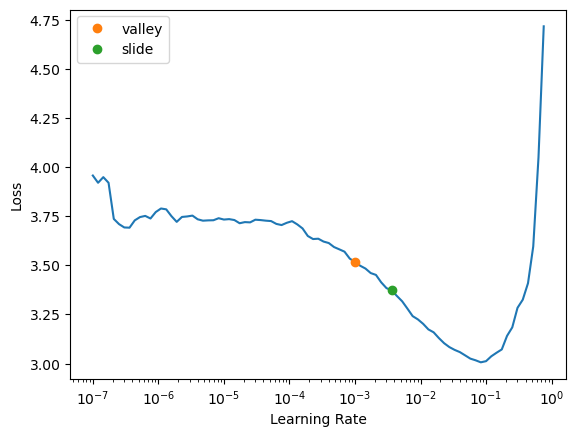

In [11]:
learn.lr_find(suggest_funcs=(valley, slide))

`lr_find` generally recommends rather conservative learning rates, to ensure that your model will train successfully. I generally like to push it a bit higher if I can. Let's train a few epochs and see how it looks:

3 에폭을 0.01 lr을 이용해 학습

In [12]:
learn.fine_tune(3, 0.01)

We're now ready to build our first submission. Let's take a look at the sample Kaggle provided to see what it needs to look like:

# Submitting to Kaggle

In [13]:
path

Path('input')

In [14]:
ss = pd.read_csv(path/"sample_submission.csv")
ss

image_id  label
0     200001.jpg    NaN
1     200002.jpg    NaN
2     200003.jpg    NaN
3     200004.jpg    NaN
4     200005.jpg    NaN
...          ...    ...
3464  203465.jpg    NaN
3465  203466.jpg    NaN
3466  203467.jpg    NaN
3467  203468.jpg    NaN
3468  203469.jpg    NaN

[3469 rows x 2 columns]

Ok so we need a CSV containing all the test images, in alphabetical order, and the predicted label for each one. We can create the needed test set using fastai like so:

In [15]:
tst_files = get_image_files(path/"test_images").sorted()
tst_dl = dls.test_dl(tst_files)

We can now get the prob of each class, and the index of the most likely class, from this test set(the 2nd thing returned by `get_preds` are the targets, which are blank for a test set, so we discard them):

In [16]:
probs, _, idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
idxs

C:\Users\jiweo\anaconda3\envs\kaggle-torch\lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
C:\Users\jiweo\anaconda3\envs\kaggle-torch\lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


tensor([7, 8, 6,  ..., 8, 1, 5])

In [17]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

We can create an apply this mapping using pandas:

In [18]:
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
results

0                       hispa
1                      normal
2                downy_mildew
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: idxs, Length: 3469, dtype: object

Kaggle expects the submission as a CSV file, so let's save it, and check the first few lines:

In [19]:
ss['label'] = results
ss.to_csv('subm.csv', index=False)
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,downy_mildew
200004.jpg,blast
200005.jpg,blast
200006.jpg,hispa
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


# Conclusion

Our initial submission is not very good(top 80% of teams) but it only took a minute to train. The important thing is that we have a good starting point to iterate froom, and we can do rapid iterations. Every step from loading the data to creating model to submitting to Kaggle is all automated and runs quickly.

Therefore, we can now try lots of things quickly and easily and use those experiments to improve our results. In the next notebook, we'll do exactly that! So if you're ready, take a look at [part 2 of the series](https://www.kaggle.com/code/jhoward/small-models-road-to-the-top-part-2/).